# Statistical Analysis of Outcrop Fracture Maps

Fractured rocks are ubiquitous in nature and important in several industries. In the oil and gas industry, about 60% of the world's oil reserves are stored in carbonate rocks which are brittle in nature and susceptible to natural fracturing due to geological processes such as folding or faulting. In the geothermal industry, water is injected into hot dry fractured rocks such that heat is absorbed and produced to the surface.

However, these processes all take place thousands of feet underground. So it's a mammoth task to understand how fracture networks look like underneath us. Fortunately, geology is not completely unforgiving. Sometimes, we can find rocks on the surface of the Earth that were formed at the same time and under the same conditions as underground rocks - we call these outcrops.

So what can we learn from outcrops? Let's try to answer this question by exploring some data that's been made public by TU Delft.

https://data.4tu.nl/repository/uuid:988152da-3ac3-44cb-9d87-c7365e3707b6

These datasets were acquired from the outcrop of the Jandaira Carbonate Formation in the Potiguar Basin, North East of Brazil. In this notebook, I will take you through the Apodi 4 dataset.

To begin, let's first import the packages that we will be needing:

In [1]:
import shapefile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

Once we have all of that set up, download the zip file from the URL and extract all files named 'apodi4.*'

Here, I will make use of the pyshp package to read the Apodi 4 shapefile. Shapefiles are a data format developed and regulated by ESRI and is widely used to store geographical data.

In [2]:
sf = shapefile.Reader('apodi4.shp')
sr = sf.shapeRecords()

## Understanding the data

To get a sense of what we are dealing with here, let's first take a look at the shape type. The shape type tells us what types of objects are represented in the dataset. As can be seen here, the shape type for object 1 is 3, which corresponds to polylines.

In [3]:
sr[0].shape.shapeType

3

Are all objects contained in this dataset of shape type 3? This can be easily checked with list comprehension.

In [4]:
all([shaperec.shape.shapeType==3 for shaperec in sr])

True

We will also want to know how many points we are dealing with per polyline. As the code below will show, we first note that object 1 has only two points, so it is a line segment. This turns out to be true for every object.

In [5]:
len(sr[0].shape.points)

2

In [6]:
all([len(shaperec.shape.points)==2 for shaperec in sr])

True

It is also worthwhile taking a look at other information associated with the object to see what's available for analysis. The particular field of interest for us here will be the length of the fractures.

In [7]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['length', 'N', 19, 11],
 ['strike', 'N', 19, 11],
 ['blocksize', 'N', 19, 11],
 ['angle', 'N', 19, 11],
 ['spacing', 'N', 19, 11],
 ['a_mech', 'N', 19, 11],
 ['a_hydro', 'N', 19, 11],
 ['linangle', 'N', 19, 11],
 ['stressangl', 'N', 19, 11]]

At this point, we have some idea regarding what we're dealing with. But it would really help if we could visualize them. Here we use matplotlib's collection library to collect line segments for plotting. As will be seen in the output, we have a very complex fracture network with a lot of fractures.

However, we can see that the fractures don't seem to be perfectly straight lines and are composed of line segments. So it seems that each line segment is only a part of a fracture.

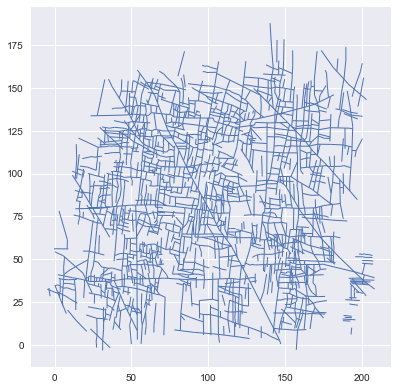

In [8]:
lines=[shaperec.shape.points for shaperec in sr]
lc = mc.LineCollection(lines,linewidths=1)

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
ax.add_collection(lc)
ax.autoscale()

If we plot only the first 200 line segments, we will see that there is definitely less than 200 fractures being plotted. Unfortunately, as there is no field in the shapefile mentioning which segments belong together, we will have to figure out a way to assign segments to fractures.

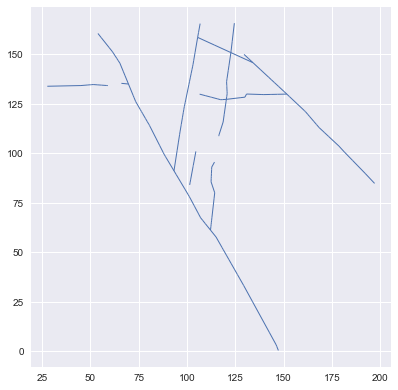

In [9]:
lines=[shaperec.shape.points for shaperec in sr[0:200]]
lc = mc.LineCollection(lines,linewidths=1)

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
ax.add_collection(lc)
ax.autoscale()

## Data Cleanup

To clean up the data, for convenience, I decided to put the necessary data into a Pandas Data Frame. In columns P1 and P2, I have maintained the end point coordinates as tuples to minimize conversions.

In [10]:
# Coordinates of segment endpoints
coords=[shaperec.shape.points for shaperec in sr] 
Segment = pd.DataFrame(data=coords, columns=['P1','P2'])

# Length of each line segment
lengths=[shaperec.record[0] for shaperec in sr]
Segment['Lengths']=lengths

In [11]:
Segment.head()

P1  \
0    (53.9409227425931, 160.38534888252616)   
1   (142.61303741298616, 9.683408826589584)   
2  (146.16394676163327, 3.3634559847414494)   
3   (146.47467674023937, 2.597217133268714)   
4    (133.8233713132795, 25.32736641354859)   

                                         P2     Lengths  
0   (55.67151139827911, 158.26442668400705)  185.699075  
1  (146.16394676163327, 3.3634559847414494)  185.699075  
2   (146.47467674023937, 2.597217133268714)  185.699075  
3    (147.317332301056, 0.5192862171679735)  185.699075  
4   (142.61303741298616, 9.683408826589584)  185.699075

We want to join fracture segments that belong to the same fracture. This is done by writing a function which assigns, in a new column, an identifier for each fracture.

In [12]:
def joinfracs(df):
    '''
    Loops through the dataframe to see which fracture segments belong to the same fracture.
    Fracture identifiers are assigned to a new column
    -------
    
    Returns:
        df (optional): with new column. Changes are made in place. Return only needed if copy of dataframe is passed as argument
    '''
    fracture=0 # current fracture identifier
    fractureindex=np.zeros((df.shape[0],1),dtype=int) # create a numpy array that holds fracture identifiers for each line segment
    P_arr = df[['P1','P2']].values # change dataframe to numpy array for speed
    lengths = df['Lengths'].values
    
    for i in range(df.shape[0]): # for every segment
        if not fractureindex[i]: # if segment has not been assigned an identifier, proceed with algorithm
            endpts = set(P_arr[i,:]) # cast end points as a set
            fracture += 1
            fractureindex[i]=fracture # assign new identifier
            
            added=1 # set as 1 to initiate while loop in next line
            while added>0: # repeat until each cycle doesn't add new segments to a fracture
                added=0
                for j in range(df.shape[0]):
                    if not fractureindex[j]: # for every unidentified segment
                        endpts_j = set(P_arr[j,:])

                        commonpt = endpts.intersection(endpts_j) # condition one: detect common endpoint
                        samelength= lengths[i]==lengths[j] # condition two: check if associated length entry is the same

                        if bool(commonpt) and samelength: # if both conditions are met
                            endpts=endpts.union(endpts_j).difference(commonpt) # set new endpoints
                            fractureindex[j]=fracture # assign current fracture identifier to segment j
                            added += 1
    
    df['Fracture']=fractureindex # attach new column
    return df

Before we use this function on the entire 'Segment' dataframe, we want to make sure it works, and that it's moderately fast enough. As can be seen below, the function seems to behave as desired.

In [13]:
test=Segment.iloc[0:2000].copy()
joinfracs(test)
test.head()

P1  \
0    (53.9409227425931, 160.38534888252616)   
1   (142.61303741298616, 9.683408826589584)   
2  (146.16394676163327, 3.3634559847414494)   
3   (146.47467674023937, 2.597217133268714)   
4    (133.8233713132795, 25.32736641354859)   

                                         P2     Lengths  Fracture  
0   (55.67151139827911, 158.26442668400705)  185.699075         1  
1  (146.16394676163327, 3.3634559847414494)  185.699075         1  
2   (146.47467674023937, 2.597217133268714)  185.699075         1  
3    (147.317332301056, 0.5192862171679735)  185.699075         1  
4   (142.61303741298616, 9.683408826589584)  185.699075         1

Now let's plot a few fractures based on fracture identifiers. As can be seen, the function is correctly identifying line segments belonging to the same fracture.

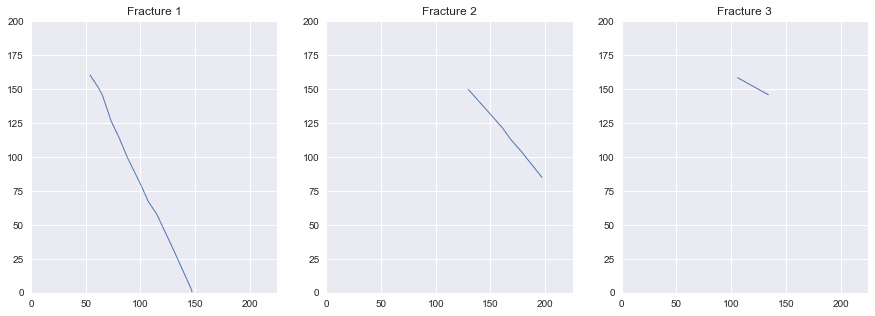

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    segments=test[test['Fracture']==i+1][['P1','P2']].values.tolist()
    lc = mc.LineCollection(segments,linewidths=1)
    ax[i].add_collection(lc)
    ax[i].set_xlim(0,225)
    ax[i].set_ylim(0,200)
    ax[i].set_title('Fracture {0}'.format(i+1))

Now, we run the function on the actual 'Segments' dataframe. This will take a longer time. But you shouldn't have to leave your computer.

In [15]:
joinfracs(Segment)
Segment.head()

P1  \
0    (53.9409227425931, 160.38534888252616)   
1   (142.61303741298616, 9.683408826589584)   
2  (146.16394676163327, 3.3634559847414494)   
3   (146.47467674023937, 2.597217133268714)   
4    (133.8233713132795, 25.32736641354859)   

                                         P2     Lengths  Fracture  
0   (55.67151139827911, 158.26442668400705)  185.699075         1  
1  (146.16394676163327, 3.3634559847414494)  185.699075         1  
2   (146.47467674023937, 2.597217133268714)  185.699075         1  
3    (147.317332301056, 0.5192862171679735)  185.699075         1  
4   (142.61303741298616, 9.683408826589584)  185.699075         1

As a sanity check, we make sure that there are no segments left unassigned. We can also use the identifiers to see the total number of fractures that was mapped for this dataset.

In [16]:
# Any unassigned segments?
any(Segment['Fracture']==0)

False

In [17]:
# Total number of fractures?
Segment['Fracture'].max()

1082

It appears that the fracture identifier might be in an ascending order as we progress down the entries in 'Segment'. If we plot out the fractures in cumulative chunks. We can actually see that the largest fractures were mapped first, followed by smaller ones. This is a rather standard procedure in the geoscientific community.

In [18]:
Segment.tail()

P1  \
4253   (148.85907458572183, 95.71200673654675)   
4254  (121.30314875615295, 114.45141290128231)   
4255  (122.14916539017577, 113.00442498549819)   
4256  (124.59784050181042, 109.63347408920527)   
4257    (104.58010279166047, 117.021802181378)   

                                            P2    Lengths  Fracture  
4253    (151.0228629304329, 95.44621784240007)  10.294496      1080  
4254  (122.14916539017577, 113.00442498549819)   8.180335      1081  
4255  (124.59784050181042, 109.63347408920527)   8.180335      1081  
4256  (126.07099674455822, 107.81832814030349)   8.180335      1081  
4257  (109.07937430799939, 115.00703901425004)   4.929778      1082

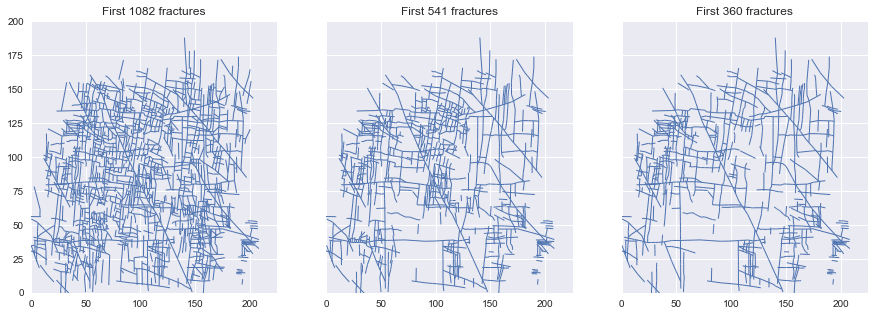

In [19]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))

for i in range(3):
    segments=Segment[Segment['Fracture']<Segment['Fracture'].max()/(i+1)][['P1','P2']].values.tolist()
    lc = mc.LineCollection(segments,linewidths=1)
    ax[i].add_collection(lc)
    ax[i].set_xlim(0,225)
    ax[i].set_ylim(0,200)
    ax[i].set_title('First {0} fractures'.format(int(np.floor(Segment['Fracture'].max()/(i+1)))))

Now that we have a 'Segment' dataframe that we can work with, we actually want to proceed further to create a dataframe based on fractures instead. This will enable us to better analyze the fracture network.

We first convert the tuples in 'Segment' to numpy arrays for easier vector calculations. Then we calculate the length of each segment, their azimuths, as well as compute the x- and y- coordinates of each line segment's centroid.

In [20]:
# Convert tuples to np arrays for easier vector calculations
Segment['P1']=Segment['P1'].apply(lambda x: np.array(x))
Segment['P2']=Segment['P2'].apply(lambda x: np.array(x))   

In [21]:
# Calculate segment length
Segment['Segment Length']=Segment[['P1','P2']].apply(lambda row: np.sqrt(((row['P1']-row['P2'])**2).sum()),axis=1)

In [22]:
# Calculate centroid coordinates
Segment[['Centroid_x','Centroid_y']]=Segment[['P1','P2']].apply(lambda row: (row['P1']+row['P2'])/2,axis=1)

In [23]:
# Calculate segment gradient
Segment['Azimuth']=(Segment['P1']-Segment['P2']).apply(lambda x: np.arctan(x[1]/x[0]))

In [24]:
Segment.head()

P1                               P2  \
0  [53.9409227426, 160.385348883]   [55.6715113983, 158.264426684]   
1  [142.613037413, 9.68340882659]   [146.163946762, 3.36345598474]   
2  [146.163946762, 3.36345598474]    [146.47467674, 2.59721713327]   
3   [146.47467674, 2.59721713327]  [147.317332301, 0.519286217168]   
4  [133.823371313, 25.3273664135]   [142.613037413, 9.68340882659]   

      Lengths  Fracture  Segment Length  Centroid_x  Centroid_y   Azimuth  
0  185.699075         1        2.737380   54.806217  159.324888 -0.886399  
1  185.699075         1        7.249190  144.388492    6.523432 -1.058895  
2  185.699075         1        0.826846  146.319312    2.980337 -1.185535  
3  185.699075         1        2.242290  146.896005    1.558252 -1.185535  
4  185.699075         1       17.944125  138.218204   17.505388 -1.058895

Now, we use a weighted average approach to calculate the azimuth and centroid of each fracture. The length of each segment will be used as a weight. To facilitate this calculation, a few extra columns will be created in Segment; these will come into play when creating the Fracture dataframe using the groupby method.

In [25]:
# Intermediate calculations
Segment['SL_Cx']=Segment['Segment Length']*Segment['Centroid_x']
Segment['SL_Cy']=Segment['Segment Length']*Segment['Centroid_y']
Segment['SL_Az']=Segment['Segment Length']*Segment['Azimuth']

In [26]:
Fractures=Segment.groupby('Fracture')[['Segment Length','SL_Cx','SL_Cy','SL_Az']].sum()

# Calculate final columns
Fractures['Length']=Segment.groupby('Fracture')[['Lengths']].max()
Fractures['Centroid_x']=Fractures['SL_Cx']/Fractures['Segment Length']
Fractures['Centroid_y']=Fractures['SL_Cy']/Fractures['Segment Length']
Fractures['Azimuth']=Fractures['SL_Az']/Fractures['Segment Length']

# Drop intermediate columns
Fractures.drop(['Segment Length', 'SL_Cx', 'SL_Cy', 'SL_Az'],axis=1,inplace=True)

Fractures.head()

Length  Centroid_x  Centroid_y   Azimuth
Fracture                                              
1         185.699075  100.800292   80.668790 -1.042119
2          93.956194  163.703946  117.751607 -0.758812
3          31.350072  119.858306  152.038729 -0.419317
4          75.483458   99.855829  128.276143  1.390539
5          57.777584  121.058819  136.965407  1.104007

## Preliminary Data Exploration

Now that we have cleaned up our data, let's do some visualization to learn more about this dataset. First, we can do a distribution plot on the length of the fractures. We make use of the seaborn package for this.

As can be seen, there are a lot of small fractures in the system, with a scarce number of large ones. This is quite evident in the prior plot of the overall network as well.

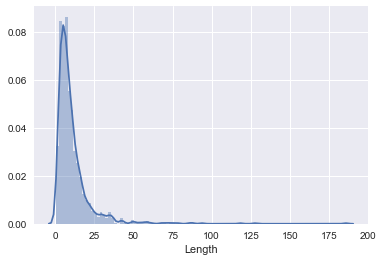

In [27]:
sns.distplot(Fractures['Length'],bins=100);

We can actually perform a log transformation on the length and replot this, which will show us that the fracture lengths are log-normally distributed. This is quite a widely accepted distribution for natural fractures.

That said, there has also been a growth in a competing theory which suggests that fractures follow power law scaling in nature, and that we see a lognormal distribution because of censoring and truncation effects. This means that small fractures may be too small to be measured, or that large fractures are under-sampled or truncated by the boundaries of our surveying area. 

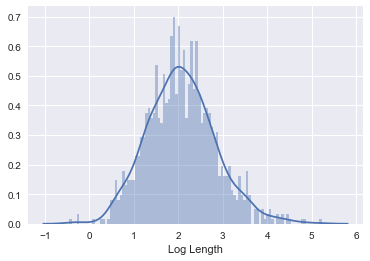

In [28]:
# Lognormal, perhaps?
ax=sns.distplot(Fractures['Length'].apply(np.log),bins=100)
ax.set_xlabel('Log Length');

Apart from length, we can also look at the distribution of fracture orientation. A quick way to do this is to plot a histogram of the 'Gradient' column, which shows three peaks. Does this mean that there are three major fracture orientations?

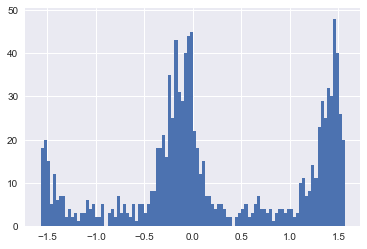

In [29]:
Fractures['Azimuth'].hist(bins=100);
# three clusters or two clusters?

In fact, there are only two fracture orientations, because the azimuth of the fractures 'wraps around', which means the peak on the left of the histogram, will join up with the peak on the right. A better visualization can be achieved using a rose diagram, which is shown below using matplotlib.

Fracture orientations are often used to cluster fractures into families. Often times, these families will also have similar geological history. As such, profiling by orientation is frequently one of the first few things to do with a fracture dataset.

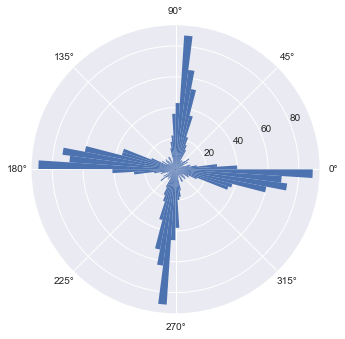

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],projection='polar')
ax.hist(pd.concat([Fractures['Azimuth'],Fractures['Azimuth']+np.pi],axis=0),bins=100);
# now it's clear there are two clusters of oriented fractures